### Data Scraping

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [140]:
response = requests.get('http://www.worldbirdnames.org/master_ioc-names_xml.xml')
soup = BeautifulSoup(response.text, 'xml')
print(response.status_code)

speciesTree = []
for o in soup.find_all('order'):
    oname = o.find('latin_name').text
    for f in o.find_all('family'):
        fname = f.find('latin_name').text
        for g in f.find_all('genus'):
            gname = g.find('latin_name').text
            gAuthority = g.find('authority').text
            rank = 0
            for s in g.find_all('species'):
                rank +=1
                sname = s.find('latin_name').text
                toApp = [rank, oname, fname, gname, sname, gAuthority, s.find('authority').text, s.find('breeding_regions').text]
                speciesTree.append(toApp)

200


### Cleaning

In [187]:
def authorCounts(data):
    SpAuths = data['SAuthors']
    GeAuths = pd.Series(data.groupby(['Genus'])['GAuthors'])
    GeAuths.index = GeAuths.map(lambda x: x[0])
    GeAuths = GeAuths.map(lambda x: x[1].iloc[0])
        
    def unlistAuthors(AList):
        ulAuths = []
        for lst in AList:
            for n in lst:
                if not n.islower():
                    print(lst, n)
                ulAuths.append(n)
        ulAuths = pd.Series(ulAuths)
        ulAuths = ulAuths.value_counts()
        
        return ulAuths
    
    SpAuths = unlistAuthors(SpAuths)
    SpAuths.name = 'SpAuthored'
    
    GeAuths = unlistAuthors(GeAuths)
    GeAuths.name = 'GenAuthored'
    
    toRet = pd.concat([GeAuths, SpAuths], axis = 'columns')
    toRet.fillna(0, inplace  = True)
    
    for c in toRet:
        toRet[c] = toRet[c].astype(int)
    
    return toRet

In [2]:
import pickle
try:
    with open('df.pickle', 'rb') as f:
        df = pickle.load(f)
    
except:
    exec(open('./Data.py').read())
    with open('df.pickle', 'rb') as f:
        df = pickle.load(f)

## Distribution Comparison

In [194]:
cts = authorCounts(df)
#cts.to_csv('authorship.csv')
spg = df.groupby(['SpG'])['Genus'].unique()
spg = spg.apply(len)
spa = cts['SpAuthored'].value_counts()
gpa = cts['GenAuthored'].value_counts()

spg = ('Species', 'Genus', spg, sum([idx*spg[idx] for idx in spg.index]))
spa = ('Species', 'Author', spa, sum([idx*spa[idx] for idx in spa.index]))
gpa = ('Genera', 'Author', gpa, sum([idx*gpa[idx] for idx in gpa.index]))

inspect module

kolmogorov-smirnoff similarity

In [11]:
def plotProp(data):
    dataP = data[2]
    dataP = [idx * data[2][idx]/data[3] for idx in data[2].index]
    plt.scatter(data[2].index, dataP)
    plt.plot([0,max(data[2].index)],[0,max(data[2].index)/data[3]], c = 'r')
    plt.ylim(0,.08)

In [202]:
def plotProp2(data):
    dataP = data[2]
    dataP = [idx * data[2][idx]/data[3] for idx in data[2].index]
    plt.scatter([i / data[3] for i in data[2].index], dataP)
    plt.plot([0,max(data[2].index)/ data[3]],[0,max(data[2].index)/data[3]], c = 'r')
    plt.ylim(0,.08)
    plt.xlim(xmin = -0.001, xmax = 0.01)

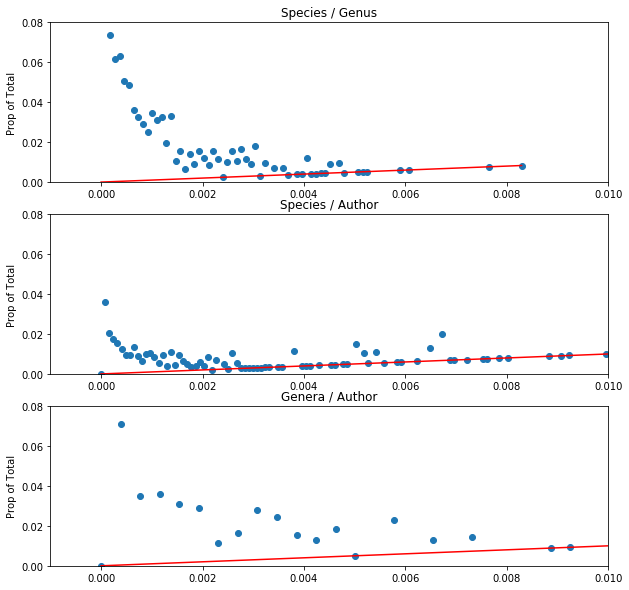

In [203]:
i = 0
plt.figure(figsize = (10,10))
for l in [spg, spa, gpa]:
    i+=1
    plt.subplot(3,1,i)
    plotProp2(l)
    plt.title(str(l[0])+' / '+str(l[1]))
    plt.ylabel('Prop of Total')

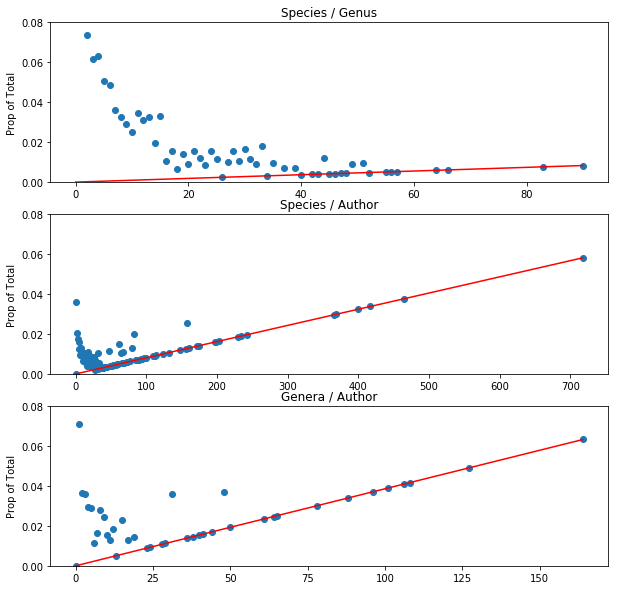

In [425]:
i = 0
plt.figure(figsize = (10,10))
for l in [spg, spa, gpa]:
    i+=1
    plt.subplot(3,1,i)
    plotProp(l)
    plt.title(str(l[0])+' / '+str(l[1]))
    plt.ylabel('Prop of Total')

Text(0.5,1,'sp / A')

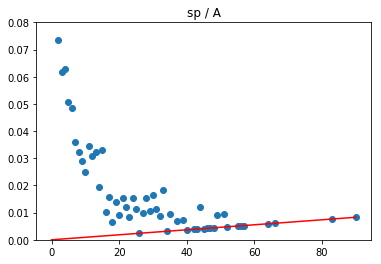

In [418]:
plotProp(spg)
plt.title('sp / A')

In [379]:
tr = []
for l in [spg, spa, gpa]:
    work = l[2].sort_index()
    try:
        work = work.drop(0)
    except:
        pass
    total = sum([idx * work[idx] for idx in work.index])
    tr.append((pd.concat([work.head(6), work.tail(6)], axis = 'rows'), total))

In [12]:
def countPlotter(x,y,log = False):
    xticks = range(1,(int(max(y)/100)+1)*100+1,100)
    yticks = range(1,(int(max(x)/100)+1)*100+1, 25)
    
    if log:
        x = np.log(x)
        y = np.log(y)
        xticks = [np.log(t) for t in  xticks]
        yticks = [np.log(t) for t in yticks]
    plt.scatter(x,y)
    for t in xticks:
        plt.axhline((t), alpha = .1)
    for t in yticks:
        plt.axvline(t, alpha = .1)

def countPlotter2(x,y,rt = False):
    xticks = range(1,(int(max(y)/100)+1)*100+1,100)
    yticks = range(1,(int(max(x)/100)+1)*100+1, 25)
    if log:
        x = x**.25
        y = y**.25
        xticks = [(t)**.25 for t in  xticks]
        yticks = [(t)**.25 for t in yticks]
    plt.scatter(x,y)
    for t in xticks:
        plt.axhline((t), alpha = .1)
    for t in yticks:
        plt.axvline(t, alpha = .1)

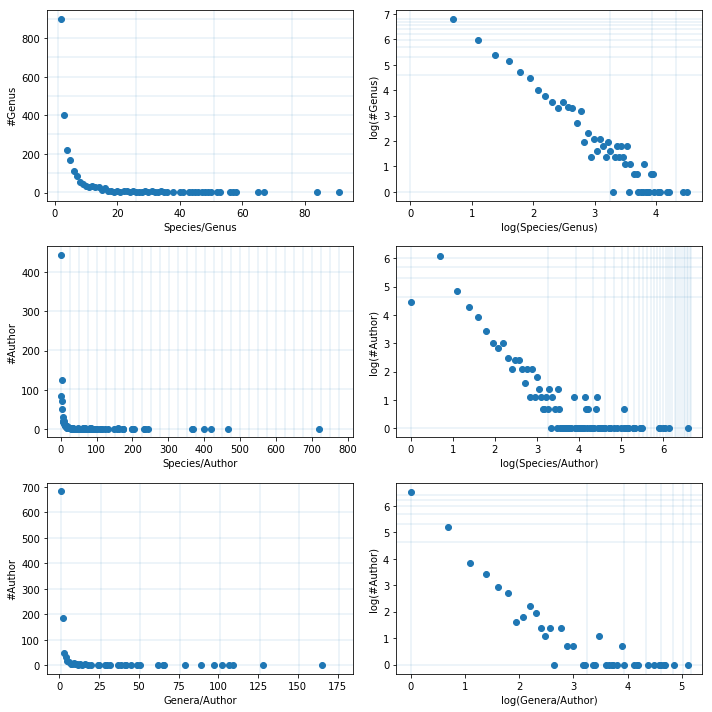

In [326]:
plt.figure(figsize = (10,10))
p = 0
for d in [spg, spa, gpa]:
    for log in [False, True]:
        p += 1
        plt.subplot(3,2,p)
        countPlotter(d[2].index+1, d[2].values, log)
        yl = '#' + d[1]
        xl = d[0] + '/' + d[1]
        ymax = 500
        xmax = 200
        
        if log:
            xl = 'log('+xl+')'
            yl = 'log('+yl+')'
            #plt.xlim(xmax = np.log(xmax))
            #plt.ylim(ymax = np.log(ymax))
        else:
            
            #plt.xlim(xmax = xmax)
            #plt.ylim(ymax = ymax)
            pass
        plt.xlabel(xl)
        plt.ylabel(yl)
plt.tight_layout()

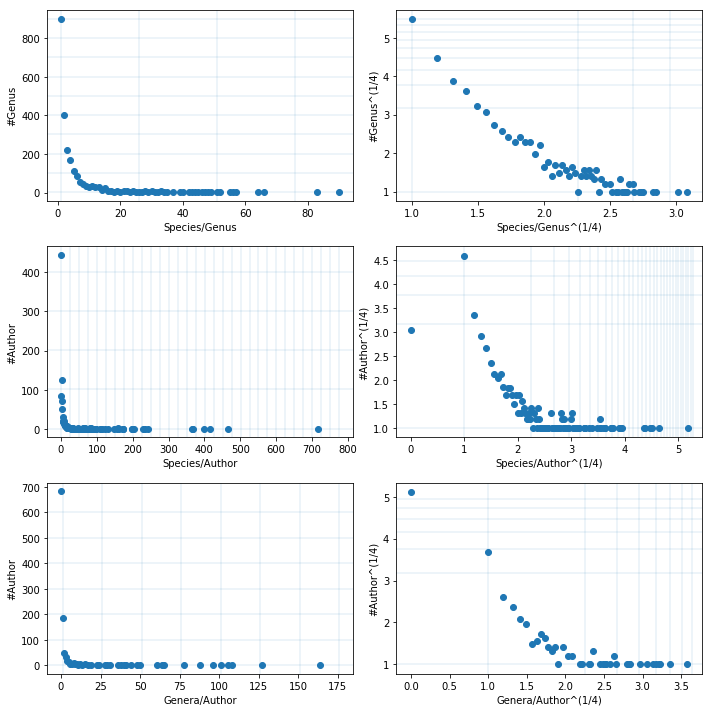

In [19]:
plt.figure(figsize = (10,10))
p = 0
for d in [spg, spa, gpa]:
    for log in [False, True]:
        p += 1
        plt.subplot(3,2,p)
        countPlotter2(d[2].index, d[2].values, log)
        yl = '#' + d[1]
        xl = d[0] + '/' + d[1]
        if log:
            xl = xl+'^(1/4)'
            yl = yl+'^(1/4)'
        plt.xlabel(xl)
        plt.ylabel(yl)
plt.tight_layout()

In [74]:
def plotCDF(tup):
    srt = tup[2].sort_index()
    dataC =[]
    for idx in srt.index:
        if idx == 0:
            dataC.append(0)
        else:         
            toAdd = idx * srt[idx] +dataC[len(dataC)-1] if len(dataC) > 0 else 0
            dataC.append(toAdd)
    if srt.index[0] == 0:
        #print('here')
        plt.plot(srt.index[1:],dataC[1:])
    else:
        plt.plot(srt.index, dataC)
    plt.title(tup[0]+ ' / ' + tup[1]+ ' CDF')
    return dataC

In [55]:
def plotLogCDF(tup):
    srt = tup[2].sort_index()
    dataC =[]
    for idx in srt.index:
        if idx == 0:
            dataC.append(0)
        else:         
            toAdd = idx * srt[idx] +dataC[len(dataC)-1] if len(dataC)>0 else 0
            dataC.append(toAdd)
    plt.plot(np.log(srt.index), np.log(dataC))
    #plt.plot([0,np.log(max(srt.index))],[0,np.log(dataC[max(srt.index)])])
    plt.title(tup[0]+ ' / ' + tup[1]+ ' CDF')
    return np.log(dataC)

In [72]:
def plotPropCDF(tup):
    srt = tup[2].sort_index()
    dataC =[]
    for idx in srt.index:
        if idx == 0:
            dataC.append(0)
        else:         
            toAdd = idx * srt[idx] +dataC[len(dataC)-1] if len(dataC)>0 else 0
            dataC.append(toAdd)
    plt.plot([i / tup[3] for i in srt.index], [d/tup[3] for d in dataC])
    plt.xlim((0,.01))
    plt.title(tup[0]+ ' / ' + tup[1]+ ' CDF')
    return dataC

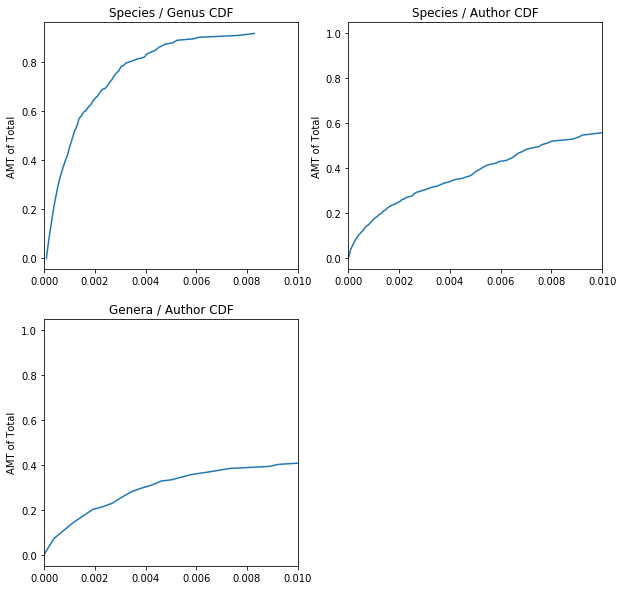

In [73]:
i = 0
ret = []
plt.figure(figsize = (10,10))
for l in [spg, spa, gpa]:
    i+=1
    plt.subplot(2,2,i)
    ret.append(plotPropCDF(l))
    plt.ylabel('AMT of Total')

C:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


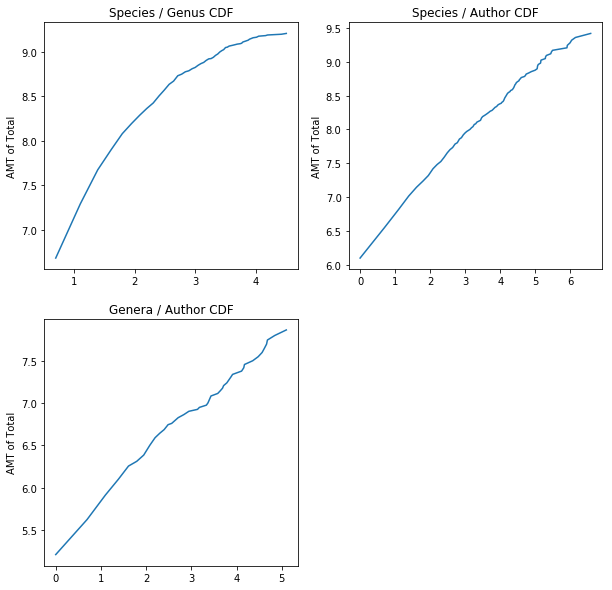

In [57]:
i = 0
ret = []
plt.figure(figsize = (10,10))
for l in [spg, spa, gpa]:
    i+=1
    plt.subplot(2,2,i)
    ret.append(plotLogCDF(l))
    plt.ylabel('AMT of Total')

here
here


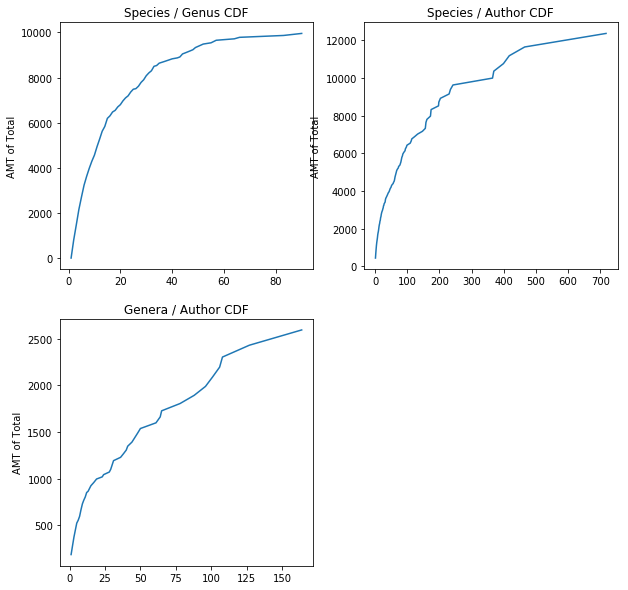

In [75]:
i = 0
plt.figure(figsize = (10,10))
for l in [spg, spa, gpa]:
    i+=1
    plt.subplot(2,2,i)
    plotCDF(l)
    plt.ylabel('AMT of Total')

values = number of authors = Y  
index = species described = X

## Grouping and Shuffling

In [209]:
def randomizeRank(data):
    dfCollect = []
    for g in data['Genus'].unique():
        work = data[data['Genus'] == g].copy()
        work['Rank'] = np.random.permutation(range(1,len(work)+1))
        dfCollect.append(work)
    return pd.concat(dfCollect, axis = 'rows')

In [210]:
def alphaRank(data):
    dfCollect = []
    for g in data['Genus'].unique():
        work = data[data['Genus'] == g].copy()
        work = work.sort_values('Species')
        work['Rank'] = range(1,len(work)+1)
        dfCollect.append(work)
    return pd.concat(dfCollect, axis = 'rows')

In [88]:
def speciesGrouper(data, gbList, gbListNames):
    split = pd.DataFrame(data.groupby(gbList)['Species'].count())
    for idx in split.index:
        for i, n in enumerate(gbListNames):
            split.loc[idx,n] = idx[i]
    split.index = range(len(split))
    return split

def fullTableMaker(data):
    tables = {}
    info = ['Species','SpG','Rank','DateRank']
    data = data.astype(int)
    sp, spg, rank, dRank = 0,0,0,0
    for row in data.iterrows():
        
        sp = row[1]['Species']
        spg = row[1]['SpG']
        rank = row[1]['Rank']
        dRank = row[1]['DateRank']
        
        if spg not in tables.keys():
            tables[spg] = {}
        if rank not in tables[spg].keys():
            tables[spg][rank] = [0] * spg
        if tables[spg][rank][dRank-1] == 0:
            tables[spg][rank][dRank-1] = sp
        else:
            print('error', spg, rank, dRank)
    return tables

def epochSplitter(data, splitter, epochs):
    grouped = speciesGrouper(data,
                             [pd.cut(data[splitter], epochs), 'SpG', 'Rank','DateRank'],
                             ['age', 'SpG', 'Rank','DateRank'] )
    ages = list(grouped['age'].unique())
    toRet = {}
    for a in ages:
        toRet[a] = fullTableMaker(grouped[grouped['age'] == a].drop('age', axis = 'columns'))
    return toRet

dfp = df.drop(['Order', 'Family','BreedRegion','OrigG','GDate','GAuthors', 'SAuthors'], axis = 'columns')
t = speciesGrouper(dfp, ['SpG','Rank', 'DateRank'], ['SpG','Rank', 'DateRank'])
tabs = fullTableMaker(t)
rag = [1758, 1815, 1916, 2020]
test = epochSplitter(dfp, 'SDate', rag)

In [3]:
exec(open('./VisualizeFuncs.py').read())

In [7]:
dfp = df.drop(['Order', 'Family','BreedRegion','OrigG','GDate','GAuthors', 'SAuthors'], axis = 'columns')
t = speciesGrouper(dfp, ['SpG','Rank', 'DateRank'], ['SpG','Rank', 'DateRank'])
tabs = fullTableMaker(t)
rag = [1758, 1815, 1916, 2020]
test = epochSplitter(dfp, 'SDate', rag)

In [75]:
print(pd.DataFrame(test[list(test.keys())[2]][3]))

   1   2   3
0  1   0   0
1  2   3   4
2  5  10  13


In [79]:
tabagg3 = speciesRankDateAgg3OrMore(tabs)

In [80]:
pd.DataFrame(tabagg3)

,1,2,3,4,5,6,7,8,9,10,...,81,82,83,84,85,86,87,88,89,90
1,"[365, 189.046741364, 1010]","[184, 189.046741364, 1010]","[166, 189.046741364, 1010]","[129, 114.71340803, 787]","[78, 71.9634080303, 616]","[55, 49.9634080303, 506]","[34, 35.2967413637, 418]","[29, 27.2967413637, 362]","[23, 21.7967413637, 318]","[26, 17.9078524748, 283]",...,"[1, 0.0231593038822, 2]","[1, 0.0231593038822, 2]","[0, 0.0231593038822, 2]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[1, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]"
2,"[178, 189.046741364, 1010]","[212, 189.046741364, 1010]","[178, 189.046741364, 1010]","[97, 114.71340803, 787]","[62, 71.9634080303, 616]","[52, 49.9634080303, 506]","[30, 35.2967413637, 418]","[22, 27.2967413637, 362]","[20, 21.7967413637, 318]","[17, 17.9078524748, 283]",...,"[0, 0.0231593038822, 2]","[0, 0.0231593038822, 2]","[0, 0.0231593038822, 2]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]"
3,"[159, 189.046741364, 1010]","[195, 189.046741364, 1010]","[209, 189.046741364, 1010]","[113, 114.71340803, 787]","[68, 71.9634080303, 616]","[44, 49.9634080303, 506]","[36, 35.2967413637, 418]","[29, 27.2967413637, 362]","[21, 21.7967413637, 318]","[11, 17.9078524748, 283]",...,"[0, 0.0231593038822, 2]","[0, 0.0231593038822, 2]","[0, 0.0231593038822, 2]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]"
4,"[79, 114.71340803, 787]","[118, 114.71340803, 787]","[114, 114.71340803, 787]","[122, 114.71340803, 787]","[87, 71.9634080303, 616]","[47, 49.9634080303, 506]","[39, 35.2967413637, 418]","[27, 27.2967413637, 362]","[20, 21.7967413637, 318]","[13, 17.9078524748, 283]",...,"[0, 0.0231593038822, 2]","[0, 0.0231593038822, 2]","[0, 0.0231593038822, 2]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]"
5,"[45, 71.9634080303, 616]","[65, 71.9634080303, 616]","[81, 71.9634080303, 616]","[70, 71.9634080303, 616]","[74, 71.9634080303, 616]","[52, 49.9634080303, 506]","[41, 35.2967413637, 418]","[27, 27.2967413637, 362]","[23, 21.7967413637, 318]","[25, 17.9078524748, 283]",...,"[0, 0.0231593038822, 2]","[0, 0.0231593038822, 2]","[0, 0.0231593038822, 2]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]"
6,"[39, 49.9634080303, 506]","[51, 49.9634080303, 506]","[48, 49.9634080303, 506]","[45, 49.9634080303, 506]","[37, 49.9634080303, 506]","[41, 49.9634080303, 506]","[51, 35.2967413637, 418]","[35, 27.2967413637, 362]","[20, 21.7967413637, 318]","[22, 17.9078524748, 283]",...,"[0, 0.0231593038822, 2]","[0, 0.0231593038822, 2]","[0, 0.0231593038822, 2]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]"
7,"[24, 35.2967413637, 418]","[34, 35.2967413637, 418]","[27, 35.2967413637, 418]","[34, 35.2967413637, 418]","[40, 35.2967413637, 418]","[33, 35.2967413637, 418]","[34, 35.2967413637, 418]","[32, 27.2967413637, 362]","[28, 21.7967413637, 318]","[14, 17.9078524748, 283]",...,"[0, 0.0231593038822, 2]","[0, 0.0231593038822, 2]","[0, 0.0231593038822, 2]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[0, 0.0111111111111, 1]","[1, 0.0111111111111, 1]","[0, 0.0111111111111, 1]"
8,"[18, 27.2967413637, 362]","[25, 27.2967413637, 362]","[28, 27.2967413637, 362]","[30, 27.2967413637, 362]","[28, 27.2967413637, 362]","[34, 27.2967413637, 362]","[24, 27.296

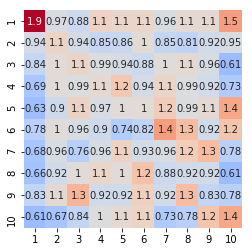

In [82]:
cols = []
t = pd.DataFrame(tabagg3).loc[0:10,0:10]#.apply(lambda x: x[0]/x[1], axis = 'columns')
for c in t:
    cols.append(t[c])
cols2 = []
for c in cols:
    cols2.append(c.apply(lambda x: x[0]/x[1]))

t = pd.concat(cols2, axis = 'columns')
sns.heatmap(t, annot = True, center = 1, cmap = 'coolwarm', square = True, cbar = False)

In [50]:
rag = [1758, 1815, 1916, 2020]

In [5]:
ages = list(test.keys())
test2 = {k:speciesRankDateAgg2(test[k]) for k in test}

In [27]:
for e in r0[1]:
    print(e)

[7, 13.37450705641108, 49]
[0, 34.636596590375618, 111]
[0, 14.360297640320523, 78]
[0, 11.089027488903307, 80]
[0, 5.7001225958424104, 50]
[0, 4.1271352231646361, 42]
[0, 3.0930695874078227, 40]
[0, 1.8742807192807192, 27]
[0, 2.196941800316413, 34]
[0, 1.7969342125882373, 27]


In [34]:
toRet = {}
for k in test2:
    toRet[k] = {}
    work = toRet[k]
    for r in pd.DataFrame(test2[k]).loc[0:10, 1:10].iterrows():
        rank = r[0]
        info = r[1]
        work[rank] = [0]*2

        for e in info:
            work[rank][0] += e[0]
            work[rank][1] += e[1]

In [60]:
cols = []
t = pd.DataFrame(toRet)#.apply(lambda x: x[0]/x[1], axis = 'columns')
for c in t:
    cols.append(t[c])
    #print(t[c], type(t[c]))
    #t[c] = pd.Series(t[c]).apply(lambda x: x[0]/x[1])

In [59]:
cols

[Interval(1758, 1815, closed='right')]

In [64]:
cols = []
t = pd.DataFrame(toRet)#.apply(lambda x: x[0]/x[1], axis = 'columns')
for c in t:
    cols.append(t[c])
cols2 = []
for c in cols:
    cols2.append(c.apply(lambda x: x[0]/x[1]))

t = pd.concat(cols2, axis = 'columns')
sns.heatmap(t, annot = True, center = 1, cmap = 'coolwarm', square = False, cbar = False)

In [70]:
t

,"(1758, 1815]","(1815, 1916]","(1916, 2020]"
1,2.365059,0.726750,0.075882
2,1.343671,0.973611,0.715456
3,0.915482,1.095681,0.576142
4,0.646472,1.114817,0.852706
5,0.557094,1.107296,1.169524
6,0.513361,1.109282,1.014834
7,0.264397,1.111510,1.230212
8,0.218150,1.110093,1.117078
9,0.268483,1.145921,1.409672
10,0.119908,1.074813,1.572809


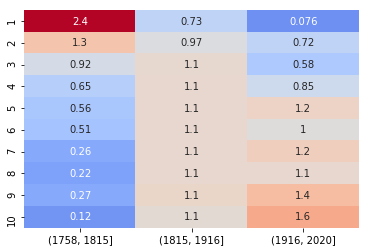

In [69]:
sns.heatmap(t, annot = True, center = 1, cmap = 'coolwarm', square = False, cbar = False)

In [21]:
t = pd.DataFrame(test2[list(test2.keys())[2]]).loc[0:10, 1:10]

In [83]:
ages = list(test.keys())
test2 = {k:speciesRankDateAgg3OrMore(test[k]) for k in test}

C:\Users\William\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


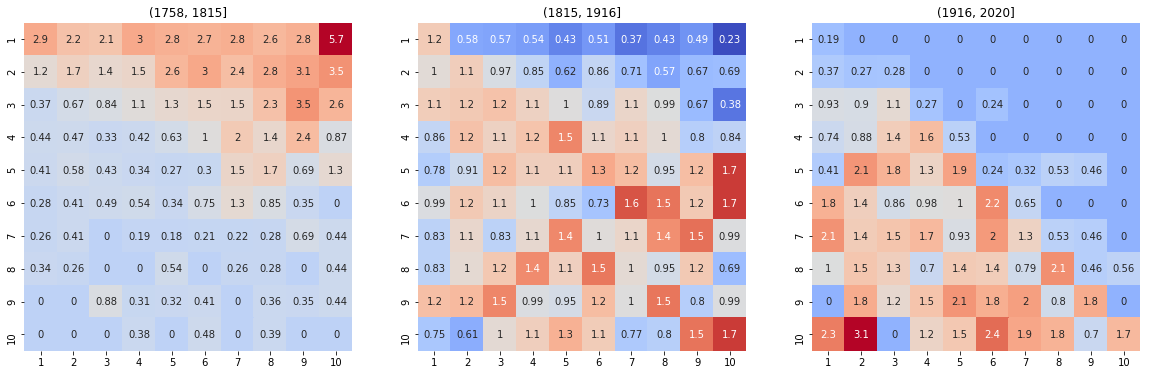

In [86]:
plt.figure(figsize = (20,20))
i = 0
for k in test2:
    tab = test2[k]
    i+=1
    plt.subplot(1,3,i)
    
    tabdf = pd.DataFrame(tab)
    tabdf = tabdf[list(range(1,11))]
    tabdf = tabdf.loc[1:10,:]
    for c in tabdf:
        #print(test[c])
        tabdf[c] = tabdf[c].apply(prop)
    tabdf.head()
    
    plt.subplot(1,3,i)
    sns.heatmap(tabdf, annot = True, center = 1,
                        cmap = 'coolwarm', square = True, cbar = False)
    plt.title(str(k))

In [15]:
import scipy.stats as stats

def absZScore(entry):
    obs = entry[0]
    exp = entry[1]
    n = entry[2]
    return abs(((obs/n - exp/n)/ (((exp/n)*(1-(exp/n)))/n)**.5))

def prop(entry):
    return entry[0]/entry[1]

def pVal(entry):
    return stats.norm.cdf(-absZScore(entry))

def hMapper(agg, func = prop, name = 'test', center = 1, cmap = 'coolwarm'):
    df = pd.DataFrame(agg)
    df = df.loc[1:10, 1:10]
    df = df.apply(func, axis = 'columns')
    sns.heatmap(df, annot = True, center = center,
               cmap = cmap, square = True,
               cbar = False)
    plt.title(name)

In [76]:
exec(open('./VisualizeFuncs.py').read())

In [149]:
def speciesRankDateHeat(tables, title):
    locs = {1:(1,1),2:(1,2),3:(1,4),4:(1,7),5:(1,11),6:(1,16),7:(7,15),8:(6,1),9:(15,1),10:(14,12)}
    plt.figure(figsize = (20,20))
    
    i = 0
    for k in tables:
        i+=1

        temp = pd.DataFrame(tables[k])
        temp.index = range(1,len(temp)+1)
        
        for c in temp:
            temp[c] = [e/temp[c].sum()/(1/len(temp)) for e in temp[c]]
            temp[c] = [e/2.6 for e in temp[c]]
            
        where = locs[i]
        plt.subplot2grid((23,21),(where[0]-1, where[1]-1), colspan = i, rowspan = i)
        sns.heatmap(temp, annot = True, center = .5,
                    cmap = 'coolwarm', square = True, cbar = False)
    
    plt.subplot2grid((23,21),(5,8), colspan = 5, rowspan = 5)
    plt.axis('equal')
    plt.axis('off')
    
    plt.text(-0.05,-0.01,'species Rank', rotation = 'vertical', fontsize = 28)#, horizontalalignment = 'right')
    plt.text(-0.036,-0.08,'Date Rank', rotation = 'horizontal', fontsize = 24)#, horizontalalignment = 'left')
    plt.text(0.009,0.00,'Proportion\n of\n species\n'+title, fontsize = 30, horizontalalignment = 'center')

In [279]:
def speciesRankDateAgg(tables):
    agg = {}

    for spg in tables:
        if spg == 1:
            pass
        else:
            
            temp = pd.DataFrame(tables[spg])
            temp.index = range(1,len(temp)+1)

            obs = 0
            for c in temp:
                obs += temp[c].sum()

            genera = obs / spg

            # expected  = genera * 1/spg for all spg
            # Actual = sum for each location.

            for dRank in temp:
                if dRank not in agg.keys():
                    agg[dRank] = {}
                for rank in temp[dRank].index:
                    if rank not in agg[dRank].keys():
                        agg[dRank][rank] = [0, 0, 0 ]
                    agg[dRank][rank][1] += genera * (1/spg)
                    agg[dRank][rank][0] += temp.loc[rank,dRank] 
                    agg[dRank][rank][2] += genera

    return agg

In [78]:
realAgg = speciesRankDateAgg(realtabs)
ranAgg = speciesRankDateAgg(randomtabs)
alphaAgg = speciesRankDateAgg(alphatabs)

NameError: name 'realtabs' is not defined

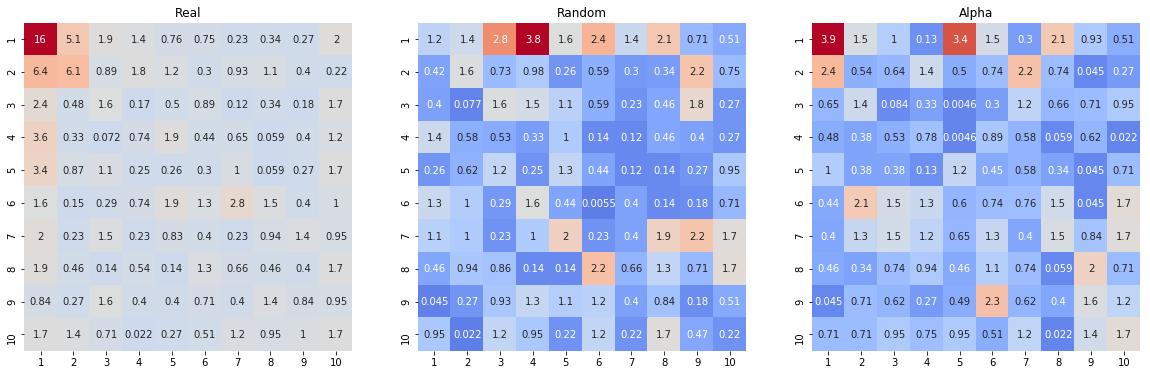

In [303]:
plt.figure(figsize = (20,20))
i = 0
for tab, name in zip([realAgg, ranAgg, alphaAgg], ['Real','Random','Alpha']):
    i+=1
    test = pd.DataFrame(tab)
    for c in test:
        test[c] = test[c].apply(lambda x: abs(((x[0]/x[2] - x[1]/x[2])/ (((x[1]/x[2])*(1-(x[1]/x[2])))/x[2])**.5)))
    test = test[list(range(1,11))]
    test = test.loc[1:10,:]
    plt.subplot(1,3,i)
    sns.heatmap(test, annot = True, center = 1.64,
                        cmap = 'coolwarm', square = True, cbar = False)
    plt.title(name)

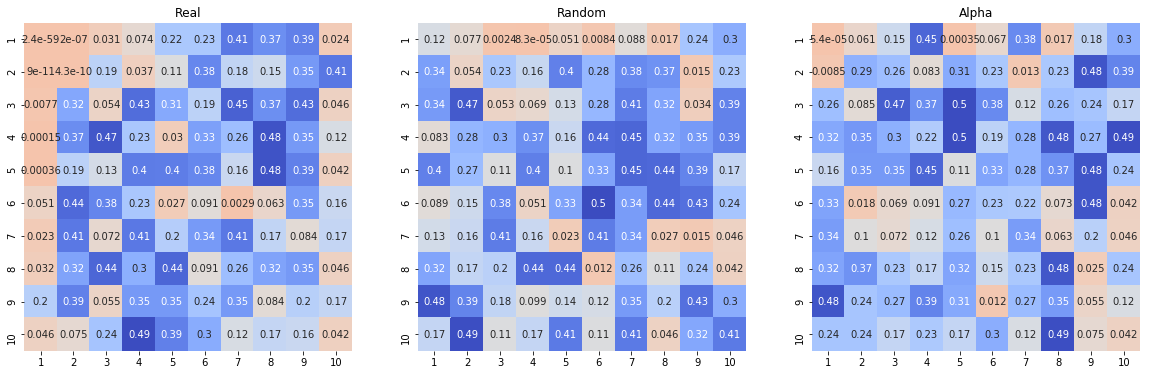

In [306]:
plt.figure(figsize = (20,20))
i = 0
for tab, name in zip([realAgg, ranAgg, alphaAgg], ['Real','Random','Alpha']):
    i+=1
    test = pd.DataFrame(tab)
    for c in test:
        test[c] = test[c].apply(lambda x: stats.norm.cdf(-abs((x[0]/x[2] - x[1]/x[2])/ (((x[1]/x[2])*(1-(x[1]/x[2])))/x[2])**.5)))
    test.head()
    test = test[list(range(1,11))]
    test = test.loc[1:10,:]
    plt.subplot(1,3,i)
    sns.heatmap(test, annot = True, center = 0.1,
                        cmap = 'coolwarm_r', square = True, cbar = False)
    plt.title(name)

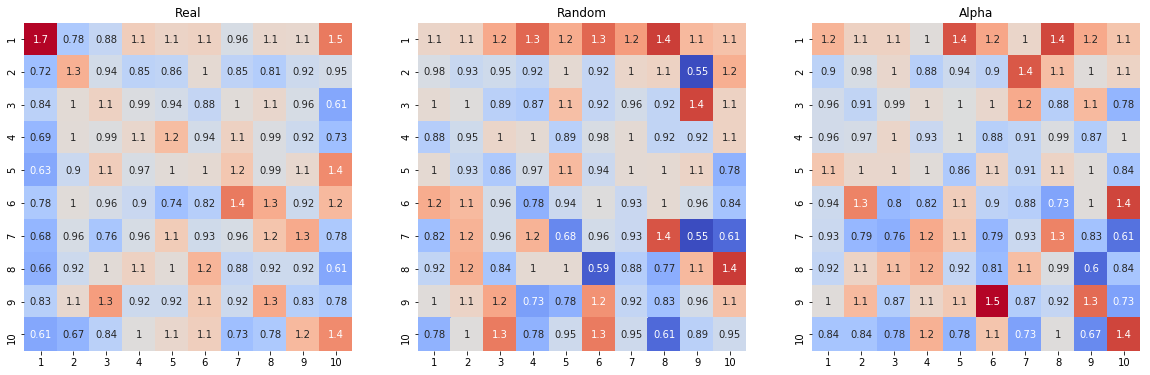

In [307]:
plt.figure(figsize = (20,20))
i = 0
for tab, name in zip([realAgg, ranAgg, alphaAgg], ['Real','Random','Alpha']):
    i+=1
    test = pd.DataFrame(tab)
    for c in test:
        test[c] = test[c].apply(lambda x: x[0]/x[1])
    test.head()
    test = test[list(range(1,11))]
    test = test.loc[1:10,:]
    plt.subplot(1,3,i)
    sns.heatmap(test, annot = True, center = 1,
                        cmap = 'coolwarm', square = True, cbar = False)
    plt.title(name)

In [91]:
dfb = df.drop(['Order','Family','Genus','BreedRegion','SAuthors','GAuthors'], axis = 'columns')
dfb.head()

,Rank,Species,OrigG,SDate,GDate,DateRank,SpG
0,1,camelus,True,1758,1758,1,2
1,2,molybdophanes,True,1883,1758,2,2
2,1,americana,False,1758,1760,1,2
3,2,pennata,True,1834,1760,2,2
4,1,australis,True,1813,1813,1,5


In [93]:
bi = dfb[dfb['SpG']==2]
bi['prev'] = bi['SDate'] < bi['GDate']
bi.head()

C:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Rank,Species,OrigG,SDate,GDate,DateRank,SpG,prev
0,1,camelus,True,1758,1758,1,2,False
1,2,molybdophanes,True,1883,1758,2,2,False
2,1,americana,False,1758,1760,1,2,True
3,2,pennata,True,1834,1760,2,2,False
42,1,rufescens,False,1815,1825,1,2,True


In [107]:
bitab = speciesGrouper(bi, ['Rank','DateRank','SpG', 'prev', 'OrigG'], ['Rank','DateRank','SpG', 'prev', 'OrigG'])

In [113]:
tabs = []
for pr in bitab['prev'].unique():
    for orig in bitab['OrigG'].unique():

        print(pr, orig)
        tabs.append(fullTableMaker(bitab[(bitab['prev']==pr)&(bitab['OrigG'] == orig)]))

False False
False True
True False
True True


In [171]:
typeSpecies = pd.read_table('./typelst.txt', header = None)
typeSpecies['Genus'] =[e[0] for e in typeSpecies[0].str.split('_')]
typeSpecies['Species'] = [e[1] for e in typeSpecies[0].str.split('_')]
typeSpecies = typeSpecies.drop(0, axis = 'columns')
typeSpecies = typeSpecies.drop_duplicates()
typeSpecies['Species'] = typeSpecies['Species'].str.replace('&#8224','')
typeSpecies['Type'] = True
df = df.merge(typeSpecies, how = 'left', on = ['Genus','Species'])
df['Type'].fillna(False, inplace = True)

(10857, 14)

In [167]:
df.shape

(10857, 13)

In [190]:
list(enumerate(ser.index.names))

[(0, None)]

In [210]:
ser = pd.DataFrame(dft.groupby(['Genus','Type', 'SpG'])['Species'].count())

for idx in ser.index:
    for i, e in enumerate(ser.index.names):
        ser.loc[idx,e] = idx[i]
ser.index = range(len(ser))
ser['SpG'] = ser['SpG'].astype(int)

In [200]:
print(dft[(dft['Type']==True)& (dft['SpG'] ==1)][['Genus','Species']])

                Genus          Species
12           Dromaius  novaehollandiae
3472           Aceros       nipalensis
4264        Psephotus     haematonotus
4365     Glossopsitta         concinna
4996        Myrmeciza         longipes
5521         Pitangus      sulphuratus
5534      Empidonomus           varius
6883       Melampitta         lugubris
8408      Thryothorus     ludovicianus
9769   Coccothraustes   coccothraustes
9772         Pinicola       enucleator
10283         Curaeus          curaeus
10298         Seiurus      aurocapilla


In [211]:
ser.head()

,Species,Genus,Type,SpG
0,1,Abeillia,False,1
1,2,Abroscopus,False,3
2,1,Abroscopus,True,3
3,1,Aburria,False,1
4,1,Acanthagenys,False,1


In [227]:
pd.DataFrame(toRet).to_csv('./NoType.csv')

In [225]:
toRet = []
for g in ser['Genus'].unique():
    if ser[ser['Genus'] == g].iloc[0]['SpG'] >1:
        
        if len(ser[((ser['Genus'] == g) & (ser['Type']==True))]) == 0:
            toRet.append(g)


In [173]:
dft.groupby(['SpG', 'Type'])['Species'].count()

SpG  Type 
1    False    889
     True      13
2    False    446
     True     354
3    False    460
     True     209
4    False    528
     True     156
5    False    445
     True     105
6    False    444
     True      84
7    False    338
     True      54
8    False    311
     True      41
9    False    280
     True      35
10   False    246
     True      24
11   False    341
     True      33
12   False    309
     True      27
13   False    326
     True      25
14   False    195
     True      15
15   False    337
     True      23
             ... 
44   False    129
     True       3
45   False     44
     True       1
46   False     45
     True       1
47   False     46
     True       1
48   False     47
     True       1
49   False     96
     True       2
51   False    100
     True       2
52   False     51
     True       1
55   False     54
     True       1
56   False     55
     True       1
57   False     56
     True       1
64   False     63
     True       1

In [169]:
dft['Type'].sum()

1325

In [166]:
typeSpecies.head()

,Genus,Species,Type
0,Tinamus,major,True
1,Nothocercus,julius,True
2,Crypturellus,tataupa,True
3,Rhynchotus,rufescens,True
4,Nothoprocta,perdicaria,True


In [163]:
t = pd.DataFrame(toret)
t.to_csv('./typeSErr.csv')

In [160]:
toret = []
for row in typeSpecies.iterrows():
    g = row[1]['Genus']
    s = row[1]['Species']
    gmask = (gs['Genus']==g)
    smask = (gs['Species']==s)
    toprint = ''
    ga = len(gs[gmask]) == 0
    sa = len(gs[smask]) == 0
    
    if ga | sa:
        toret.append(str(g) + ' ' + str(s))
        toprint += (str(g) +' '+ str(s)+ '\n')
    
    if ga & (not sa):
        toprint += 'Alternate Species?: \n'
        for r in gs[smask].iterrows():
            gen = r[1]['Genus']
            sp = r[1]['Species']
            toprint += (str(gen) + ' '+ str(sp) + '\n')
    
    if sa:
        toprint += 'Species Name Not Found\n'
    
    if toprint != '':
        print(toprint)
        
        

Nesoclopeus poecilopterus;
Species Name Not Found

Prosobonia leucoptera;
Species Name Not Found

Procelsterna cerulea
Alternate Species?: 
Setophaga cerulea

Alectroenas nitidissimus;
Species Name Not Found

Siphonorhis americana;
Species Name Not Found

Psephotellus pulcherrimus;
Species Name Not Found

Cyanoramphus zealandicus;
Species Name Not Found

Xenicus longipes;
Species Name Not Found

Schistocichla leucostigma
Alternate Species?: 
Myrmelastes leucostigma
Rhagologus leucostigma

Dixiphia pipra
Alternate Species?: 
Pseudopipra pipra
Iodopleura pipra

Callaeas cinereus;
Species Name Not Found

Artamus leucoryn
Species Name Not Found

Pachysylvia decurtata
Species Name Not Found

Moho nobilis;
Species Name Not Found

Orochelidon murina
Alternate Species?: 
Phaeomyias murina
Crateroscelis murina
Acanthiza murina
Notiochelidon murina
Pyrrhula murina

Phyllergates cuculatus
Species Name Not Found

Heterophasia pieaoides
Species Name Not Found

Aplonis fusca;
Species Name Not Found


In [158]:
b = True
b.

True

In [145]:
gs = df[['Genus','Species']]
gs.head()

,Genus,Species
0,Struthio,camelus
1,Struthio,molybdophanes
2,Rhea,americana
3,Rhea,pennata
4,Apteryx,australis


In [135]:
len(types)

1350

In [139]:
types[types['Genus']=='Nyctibius']

,0,Genus,Species
333,Nyctibius_grandis,Nyctibius,grandis
411,Nyctibius_grandis,Nyctibius,grandis


In [138]:
types['Genus'].value_counts()

Nyctibius         2
Xenopirostris     1
Calidris          1
Eulampis          1
Cyrtonyx          1
Paroaria          1
Butorides         1
Lagonosticta      1
Elminia           1
Lanio             1
Telophorus        1
Dendrortyx        1
Dryoscopus        1
Sicalis           1
Buteo             1
Pyrrhocorax       1
Pulsatrix         1
Coccopygia        1
Polihierax        1
Sirystes          1
Manacus           1
Thlypopsis        1
Pteruthius        1
Pseudocolaptes    1
Perisoreus        1
Pseudoleistes     1
Tityra            1
Deleornis         1
Hypocnemis        1
Toxostoma         1
                 ..
Aegithina         1
Aimophila         1
Chasiempis        1
Calypte           1
Picoides          1
Oceanodroma       1
Ictinia           1
Leptocoma         1
Moho              1
Rimator           1
Lampornis         1
Muscisaxicola     1
Calyptomena       1
Trochilus         1
Sittiparus        1
Leptodon          1
Mimus             1
Laterallus        1
Atticora          1


In [137]:
df.head()

,Rank,Order,Family,Genus,Species,BreedRegion,OrigG,SDate,SAuthors,GDate,GAuthors,DateRank,SpG
0,1,STRUTHIONIFORMES,Struthionidae,Struthio,camelus,AF,True,1758,[linnaeus],1758,[linnaeus],1,2
1,2,STRUTHIONIFORMES,Struthionidae,Struthio,molybdophanes,AF,True,1883,[reichenow],1758,[linnaeus],2,2
2,1,RHEIFORMES,Rheidae,Rhea,americana,SA,False,1758,[linnaeus],1760,[brisson],1,2
3,2,RHEIFORMES,Rheidae,Rhea,pennata,SA,True,1834,[d'orbigny],1760,[brisson],2,2
4,1,APTERYGIFORMES,Apterygidae,Apteryx,australis,AU,True,1813,[shaw],1813,[shaw],1,5


In [136]:
types.head()

,0,Genus,Species
0,Tinamus_major,Tinamus,major
1,Nothocercus_julius,Nothocercus,julius
2,Crypturellus_tataupa,Crypturellus,tataupa
3,Rhynchotus_rufescens,Rhynchotus,rufescens
4,Nothoprocta_perdicaria,Nothoprocta,perdicaria


In [134]:
len(types['Genus'].unique())

1349

In [130]:
types['Genus'] = types[0].str.split('_')[0]

ValueError: Length of values does not match length of index

In [118]:
tabs[2]

{2: {1: [241, 54], 2: [109, 89]}}

In [114]:
tabs[0]

{2: {1: [7, 20], 2: [2, 71]}}

In [86]:
import seaborn as sns
from matplotlib import gridspec
import matplotlib.colors as colors

## MODELING

In [330]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [324]:
df.corr()

,Rank,OrigG,SDate,GDate,DateRank,SpG
Rank,1.000000,0.152335,0.114212,-0.290097,0.625703,0.782884
OrigG,0.152335,1.000000,0.343556,-0.259781,0.265905,0.180661
SDate,0.114212,0.343556,1.000000,0.222873,0.449355,0.118292
GDate,-0.290097,-0.259781,0.222873,1.000000,-0.285515,-0.370550
DateRank,0.625703,0.265905,0.449355,-0.285515,1.000000,0.774143
SpG,0.782884,0.180661,0.118292,-0.370550,0.774143,1.000000


In [325]:
target = df['Rank']
tofit = ['DateRank']
X = df[tofit]

lm = LinearRegression()

lm.fit(X, target)
lm.score(X, target)

0.39150447133513577

Create predictions where if drank 1, predict 1, else predict mean

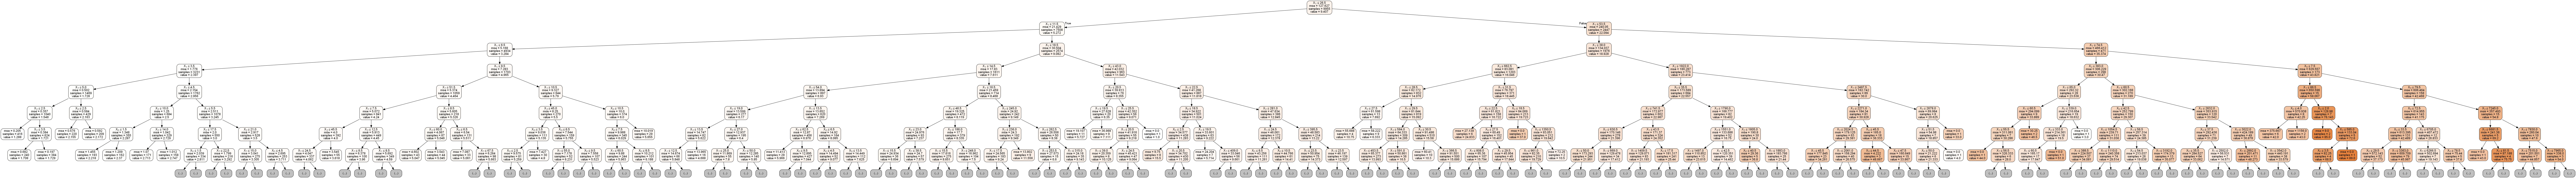

In [398]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()  

export_graphviz(modelDict['dt']['raw'], out_file=dot_data, max_depth = 7,  
                filled=True, rounded=True,
                special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [341]:
X.columns

Index(['DateRank', 'SpG', 'Interaction'], dtype='object')

In [333]:
pd.concat([pd.Series(dt.predict(X)), target], axis = 'columns')

,0,Rank
0,1.157895,1
1,1.800000,2
2,1.309192,1
3,1.800000,2
4,2.272727,1
5,2.615385,2
6,3.462963,3
7,2.666667,4
8,3.408163,5
9,1.714976,1


Need to define baseline, which would be simply guessing in the middle for each s/g

In [350]:
modeldf = df[df['SpG'] != 1]

In [349]:
from sklearn.metrics import mean_squared_error, r2_score
r2_score()


In [361]:
modeldf.head(10)

,Rank,Order,Family,Genus,Species,BreedRegion,OrigG,SDate,SAuthors,GDate,GAuthors,DateRank,SpG
0,1,STRUTHIONIFORMES,Struthionidae,Struthio,camelus,AF,True,1758,[linnaeus],1758,[linnaeus],1,2
1,2,STRUTHIONIFORMES,Struthionidae,Struthio,molybdophanes,AF,True,1883,[reichenow],1758,[linnaeus],2,2
2,1,RHEIFORMES,Rheidae,Rhea,americana,SA,False,1758,[linnaeus],1760,[brisson],1,2
3,2,RHEIFORMES,Rheidae,Rhea,pennata,SA,True,1834,[d'orbigny],1760,[brisson],2,2
4,1,APTERYGIFORMES,Apterygidae,Apteryx,australis,AU,True,1813,[shaw],1813,[shaw],1,5
5,2,APTERYGIFORMES,Apterygidae,Apteryx,mantelli,AU,True,1852,[bartlett],1813,[shaw],3,5
6,3,APTERYGIFORMES,Apterygidae,Apteryx,rowi,AU,True,2003,"[tennyson, palma, robertson, worthy, gill bj]",1813,[shaw],5,5
7,4,APTERYGIFORMES,Apterygidae,Apteryx,owenii,AU,True,1847,[gould],1813,[shaw],2,5
8,5,APTERYGIFORMES,Apterygidae,Apteryx,haastii,AU,True,1872,[potts],1813,[shaw],4,5
9,1,CASUARIIFORMES,Casuariidae,Casuarius,casuarius,AU,False,1758,[linnaeus],1760,[brisson],1,3


In [389]:
stdTarget = (modeldf['Rank']-1) / modeldf['SpG']
rawTarget = modeldf['Rank']
logTarget = np.log(modeldf['Rank'])

targetDict = {'std':stdTarget, 'raw': rawTarget, 'log':logTarget}

stdBase = [np.mean(stdTarget) for r in modeldf['Rank']]
rawBase = (modeldf['SpG']+1)/2
logBase = np.log(rawBase)
baselineDict = {'std': stdBase, 'raw':rawBase, 'log':logBase}

myPred = [1 if modeldf.loc[idx,'DateRank'] ==1 else (modeldf.loc[idx,'SpG']+1)/2 for idx in modeldf.index]
logMyPred = np.log(myPred)

tofit = ['DateRank','SpG']#, 'OrigG']
X = modeldf[tofit]
X['Interaction'] = X['DateRank']*X['SpG']

modelDict = {'lm':{}, 'dt':{}}
for t in ['std', 'raw','log']:
    modelDict['lm'][t] = LinearRegression()
    modelDict['dt'][t] = DecisionTreeRegressor()

for mod in modelDict:
    for k in modelDict[mod]:
        target = targetDict[k]
        modelDict[mod][k].fit(X, target)
        preds = modelDict[mod][k].predict(X)
        print(mod,k)
        print('mse', mean_squared_error(target, preds), mean_squared_error(target, baselineDict[k]))
        print('R^2', r2_score(target, preds), r2_score(target, baselineDict[k]),'\n')
print('raw', r2_score(rawTarget, myPred), mean_squared_error(rawTarget, myPred))
print('log', r2_score(logTarget,logMyPred), mean_squared_error(logTarget, logMyPred))

lm std
mse 0.0815027213689 0.0848314700772
R^2 0.03923954996 0.0 

lm raw
mse 51.5198553529 51.676343546
R^2 0.596325804819 0.595099670837 

lm log
mse 0.54246887521 0.532636746066
R^2 0.541237627027 0.549552594214 

dt std
mse 0.0662078665284 0.0848314700772
R^2 0.219536494321 0.0 

dt raw
mse 26.0345658217 51.676343546
R^2 0.796011026564 0.595099670837 

dt log
mse 0.377409800626 0.532636746066
R^2 0.680827004773 0.549552594214 

raw 0.543276611211 58.2903817177
log 0.401941782229 0.707180858365


C:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [329]:
lm.coef_

array([ 0.0756499 ,  0.47987966,  0.08136507, -0.00055005])

In [327]:
target = df['Rank']
tofit = ['DateRank','SpG']
X = df[tofit]
X['Interaction'] = X['DateRank']*X['SpG']

lm = LinearRegression()

lm.fit(X, target)
lm.score(X, target)

C:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.61406932056714658

In [320]:
lm.coef_

array([ 0.0493274,  0.4757684])

In [124]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Initial EDA

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [541]:
def plotSpg(data, num):
    df = data[data['SpG']==num]
    row = int(num/3)+1
    for i in range(1,num+1):
        #plt.figure(figsize = (10,8))
        plt.subplot(row,3,i)
        plt.hist(df[df['Rank'] ==i]['DateRank'])
        plt.title('Rank = '+ str(i))
        plt.xlabel('Date Rank')
        #plt.savefigfigfig(str(num) + '.png')
        #plt.ylim(ymax = 130)
        #plt.show()

## TREE SIMULATION

In [316]:
import numpy as np
def simTree(generaNum, generations, split = .1, diffDist = np.random.normal, diffThresh = 1, starterVal = [0]):
    np.random.seed(1738)
    genera = [starterVal for i in range(generaNum)]
    
    for c in range(generations):
        #print(genera)
        for i, g in enumerate(genera):
            toAddInit = []
            toAddFin = []
            for sp in g:
                if np.random.uniform() < split:
                    
                    potentialS = diffDist(sp)
                    #print(potentialS)
                    different = True
                    for s in g:
                        #print(abs(s-potentialS))
                        if abs(s-potentialS) < diffThresh:
                            #print('here')
                            different = False
                            break
                            
                    if different:
                        toAddInit.append(potentialS)
                
            #print(toAddInit)
            if len(toAddInit) >1:
                for idx, pot in enumerate(toAddInit):
                    toAdd = True
                    for idx2 in range(idx, len(toAddInit)):
                        if abs(toAddInit[idx2] - pot) < diffThresh:
                            toAdd = False
                            break
                    if toAdd:
                        toAddFin.append(pot)
            else:
                toAddFin = toAddInit
            if toAddFin != []:
                #print('here2')
                toRep = g.copy()
                toRep.extend(toAddFin)
                genera[i] = toRep
    
    return genera

In [321]:
def simTree2(generaNum, generations, split = .1, diffDist = np.random.normal, diffThresh = 1, starterVal = [0]):
    np.random.seed(1738)
    genera = [starterVal for i in range(generaNum)]
    
    for c in range(generations):
        #print(genera)
        for i, g in enumerate(genera):
            toAddInit = []
            toAddFin = []
            for sp in g:
                if np.random.uniform() < split:
                    
                    potentialS = diffDist(sp)
                    toAddInit.append(potentialS)
                
            toAddFin = toAddInit
            if toAddFin != []:
                #print('here2')
                toRep = g.copy()
                toRep.extend(toAddFin)
                genera[i] = toRep
    
    return genera

In [376]:
with open('./toRet2.pickle', 'rb') as f:
    lst = pickle.load(f)

In [384]:
lst[0][2]

[131,
 113,
 104,
 108,
 131,
 116,
 140,
 120,
 108,
 114,
 137,
 95,
 111,
 137,
 135,
 145,
 123,
 111,
 108,
 112,
 105,
 163,
 134,
 113,
 108,
 126,
 120,
 135,
 112,
 129,
 94,
 107,
 129,
 112,
 101,
 129,
 132,
 132,
 113,
 96,
 116,
 133,
 127,
 157,
 110,
 135,
 110,
 110,
 88,
 101,
 94,
 140,
 117,
 128,
 139,
 119,
 102,
 122,
 148,
 104,
 133,
 125,
 132,
 115,
 112,
 112,
 119,
 131,
 138,
 140,
 104,
 135,
 144,
 123,
 103,
 119,
 117,
 117,
 123,
 117,
 139,
 121,
 156,
 124,
 149,
 125,
 116,
 119,
 121,
 121,
 100,
 96,
 116,
 119,
 141,
 134,
 112,
 113,
 106,
 120,
 95,
 130,
 101,
 106,
 119,
 126,
 119,
 106,
 133,
 124,
 99,
 114,
 130,
 129,
 125,
 117,
 120,
 125,
 122,
 131,
 134,
 126,
 109,
 112,
 127,
 111,
 129,
 114,
 110,
 124,
 108,
 99,
 121,
 99,
 93,
 114,
 99,
 110,
 101,
 124,
 142,
 113,
 113,
 120,
 119,
 132,
 120,
 112,
 121,
 133,
 135,
 95,
 126,
 134,
 120,
 100,
 125,
 107,
 118,
 106,
 114,
 122,
 113,
 117,
 115,
 81,
 92,
 117,
 116,
 

In [322]:
%%time
st2 = simTree2(2000,100000, split = .0001, diffThresh = 2)
st2 = [len(e) for e in st2]
plt.scatter(pd.Series(st2).value_counts().index, pd.Series(st2).value_counts().values)

KeyboardInterrupt: 

Wall time: 5min 30s


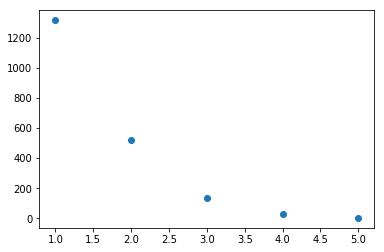

In [320]:
%%time
st2 = simTree(2000,100000, split = .0001, diffThresh = 2)
st2 = [len(e) for e in st2]
plt.scatter(pd.Series(st2).value_counts().index, pd.Series(st2).value_counts().values)

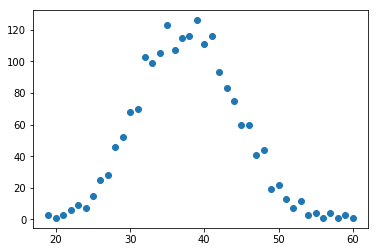

In [318]:
plt.scatter(pd.Series(st2).value_counts().index, pd.Series(st2).value_counts().values)

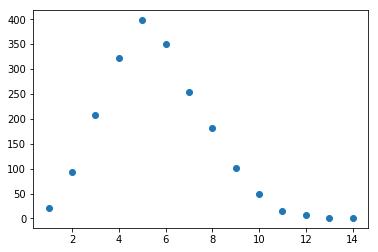

In [309]:
plt.scatter(pd.Series(st).value_counts().index, pd.Series(st).value_counts().values)

In [281]:
spParams =np.logspace(-1,-10)
diffTParam = np.linspace(.5,2.5)

In [285]:
import pickle

spParams =np.logspace(-1,-10)
diffTParam = np.linspace(.5,2.5)
toRet = []

for sp in spParams:
    for dtP in diffTParam:
        print(dtP, sp)
        st = simTree(2000, 1000, split = sp, diffThresh= dtP)
        toRet.append((sp, dtP, [len(e) for e in st]))

with open('toRet.pickle','wb') as f:
    pickle.dump(toRet,f, protocol = 0)

1 0.01
1.5 0.01
2 0.01
1 0.001
1.5 0.001
2 0.001
1 0.0001
1.5 0.0001
2 0.0001
1 1e-05
1.5 1e-05
2 1e-05
Wall time: 1min 28s


### Next Steps

It does look like there is some pattern to the rank-order an description date of the various taxa. The next thing to do will be to define and create metrics to more fully describe what those patterns are.  

Also, next it will be important to start to standardize and investigate the distriution of authorship.

split on space

# Deprecated

In [4]:
%%time
dfp = df.drop(['Order', 'Family','BreedRegion','OrigG','GDate','GAuthors', 'SAuthors'], axis = 'columns')
randomR = randomizeRank(dfp)
alphaR = alphaRank(dfp)

NameError: name 'randomizeRank' is not defined

In [299]:
realtabs = makeSpeciesRankDateTablesAll(dfp)
randomtabs = makeSpeciesRankDateTablesAll(randomR)
alphatabs = makeSpeciesRankDateTablesAll(alphaR)

In [256]:
def makeSpeciesRankDateTablesAll(data):
    
    data = pd.DataFrame(data.groupby(['SpG','Rank', 'DateRank',])['Species'].count())
    
    tables = {}
    
    currentSPG = 0
    currentRank = 0
    prevDR = 0
    full = True
    
    for idx in data.index:
        
        # index in the format (species/genus, Rank, Date Rank)
        spg = idx[0]
        rank = idx[1]
        dRank = idx[2]
        sp = data.loc[idx, 'Species']
                    
        # If the s/G changes, create new list, reset counter variables
        if spg != currentSPG:
            if not full:
                while len(tables[currentSPG][currentRank]) < currentSPG:
                    tables[currentSPG][currentRank].append(0)
                    
            tables[spg] = {}
            currentSPG = spg
            tables[spg][rank] = []
            currentRank = 1
            prevDR = 0
            full = False
        
        # If rank changes, create new list, reset dateRank counter
        if rank != currentRank:
            if not full:
                while len(tables[currentSPG][currentRank]) < currentSPG:
                    tables[currentSPG][currentRank].append(0)
                    
            tables[spg][rank] = []
            currentRank = rank
            prevDR = 0
        
        # Check to see that current date rank is only one greater than previous
        # DateRank, if not, one was skipped, in which case zeros need to be added
        if prevDR +1 != dRank:
            for i in range(dRank-prevDR-1):
                tables[spg][rank].append(0)
        
        #append number of species
        tables[spg][rank].append(sp)
        full = len(tables[spg][rank]) == currentSPG
        prevDR = dRank
    if not full:
        while len(tables[currentSPG][currentRank])<currentSPG:
            tables[currentSPG][currentRank].append(0)
    return tables    

In [427]:
%%timeit
realtabs = makeSpeciesRankDateTablesAll(dfp)
randomtabs = makeSpeciesRankDateTablesAll(randomR)
alphatabs = makeSpeciesRankDateTablesAll(alphaR)

2.59 s ± 197 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [426]:
%%timeit
realtabs = makeSpeciesRankDateTables(dfp)
randomtabs = makeSpeciesRankDateTables(randomR)
alphatabs = makeSpeciesRankDateTables(alphaR)

3.01 s ± 472 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [422]:
def makeSpeciesRankDateTables(data):
    
    data = pd.DataFrame(data.groupby(['SpG','Rank', 'DateRank',])['Species'].count())

    # tables will have the structure:
    # {SpG: {Rank: [<list>]}}
    # The [<list>] will be the number of species that are in a genera with 
    # that particular SpG, are of that Rank, and are of the DateRank
    # corresponding to the index location of the list plus 1
    tables = {}
    
    currentSPG = 0
    currentRank = 0
    prevDR = 0
    
    for idx in data.index:
        
        # MultiIndex in the format: (SpG, Rank, Date Rank)
        spg = idx[0]
        rank = idx[1]
        dRank = idx[2]
        sp = data.loc[idx, 'Species']
                    
        # If the SpG changes, create new list, reset counter variables
        if spg != currentSPG:                 
            tables[spg] = {}
            currentSPG = spg
            tables[spg][rank] = []
            currentRank = 1
            prevDR = 0
            
        
        # If rank changes, create new list, reset dateRank counter
        if rank != currentRank:               
            tables[spg][rank] = []
            currentRank = rank
            prevDR = 0
        
        # Check to see that current date rank is only one greater than previous
        # DateRank, if not, one was skipped, in which case zeros need to be added
        if prevDR +1 != dRank:
            for i in range(dRank-prevDR-1):
                tables[spg][rank].append(0)
        
        # append number of species
        tables[spg][rank].append(sp)
        prevDR = dRank
    
    # Check to ensure each list is properly filled
    for spg in tables:
        for rank in tables[spg]:
            while len(tables[spg][rank]) < spg:
                tables[spg][rank].append(0)
                
    return tables


In [20]:
df2 = pd.DataFrame(df.groupby(['SpG','Rank', 'DateRank',])['Species'].count())

In [676]:
df2.head()

Species
SpG Rank DateRank         
1   1    1             902
2   1    1             296
         2             104
    2    1             120
         2             280

In [9]:
# Requires Raw Data

def authorCounts(data):
    SpAuths = data['SAuthors']
    GeAuths = data.groupby(['Genus'])['GAuthors'].unique()
    SpAuths = [authorSplit(e) for e in SpAuths]
    GeAuths = [authorSplit(e[0]) for e in GeAuths]
    
    def unlistAuthors(AList):
        ulAuths = []
        for lst in AList:
            for n in lst:
                ulAuths.append(n)
        ulAuths = pd.Series(ulAuths)
        ulAuths = ulAuths.value_counts()
        
        return ulAuths
    
    SpAuths = unlistAuthors(SpAuths)
    SpAuths.name = 'SpAuthored'
    GeAuths = unlistAuthors(GeAuths)
    GeAuths.name = 'GenAuthored'
    toRet = pd.concat([GeAuths, SpAuths], axis = 'columns')
    toRet.fillna(0, inplace  = True)
    for c in toRet:
        toRet[c] = toRet[c].astype(int)
    
    return toRet

In [255]:
def makeSpeciesRankDateTablesOLD(data):
    
    data = pd.DataFrame(data.groupby(['SpG','Rank', 'DateRank',])['Species'].count())
    
    tables = {}
    
    currentSPG = 0
    currentRank = 0
    prevDR = 0
    full = True
    
    for idx in data.index:
        
        # index in the format (species/genus, Rank, Date Rank)
        spg = idx[0]
        
        if spg >10:
            break
            
        rank = idx[1]
        dRank = idx[2]
        
        sp = data.loc[idx, 'Species']
        
        # If the s/G changes, create new list, reset counter variables
        if spg != currentSPG:
            if not full:
                while len(tables[currentSPG][currentRank]) < currentSPG:
                    tables[currentSPG][currentRank].append(0)
                    
            tables[spg] = {}
            currentSPG = spg
            tables[spg][rank] = []
            currentRank = 1
            prevDR = 0
            full = False
        
        # If rank changes, create new list, reset dateRank counter
        if rank != currentRank:
            if not full:
                while len(tables[currentSPG][currentRank]) < currentSPG:
                    tables[currentSPG][currentRank].append(0)
                    
            tables[spg][rank] = []
            currentRank = rank
            prevDR = 0
        
        # Check to see that current date rank is only one greater than previous
        # DateRank, if not, one was skipped, in which case zeros need to be added
        if prevDR +1 != dRank:
            for i in range(dRank-prevDR-1):
                tables[spg][rank].append(0)
        
        #append number of species
        tables[spg][rank].append(sp)
        full = len(tables[spg][rank]) == currentSPG
        prevDR = dRank
    if not full:
        while len(tables[currentSPG][currentRank])<currentSPG:
            tables[currentSPG][currentRank].append(0)
    return tables    

In [243]:
SA = raw['SAuthors']
SAsp = pd.Series([authorSplit(e) for e in SA])
GA = raw['GAuthors']
GAsp = pd.Series([authorSplit(e) for e in GA])

In [244]:
sm = ['de','da','sr','la','le','jr','du','do','zu']
bef = ['zu','du', 'la'] #Du Bus de Gisignies, La Touche, Da Silva Maia
med = ['du', 'la'] # Barboza du Bocage, de la Llave, 
unk = ['do','le']
post = ['jr','sr']
test = ['da']

In [246]:
probs = []
for idx in GAsp.index:
    try:
        for n in GAsp[idx]:
            if n in sm:
                probs.append(idx)
    except:
        print('whoops', idx)
Ghard = list(raw.loc[probs,'GAuthors'].unique())
Ghard

['Le Maout',
 'Raposo do Amaral EtAl',
 'Du Bus de Gisignies',
 'zu Wied-Neuwied',
 'De Roo',
 'de la Llave',
 'De Vis',
 'de Sélys-Longchamps',
 'de Filippi']

In [247]:
for n in Ghard:
    if n not in hard:
        hard.append(n)

In [255]:
hard

['zu Wied-Neuwied',
 'Meyer de Schauensee',
 'Barboza du Bocage',
 'Meyer de Schauensee',
 'de Sélys-Longchamps',
 'Du Bus de Gisignies',
 'Gurney Sr',
 'de Sparre',
 'Gurney Jr',
 'Xántus de Vésey',
 'Da Silva Maia',
 'de la Llave',
 'de Filippi',
 'Phelps Jr',
 'Cardoso da Silva Novaes',
 'Wetmore Phelps Jr',
 'Giraud Jr',
 'De Vis',
 'De Roo',
 'La Touche',
 'Marshall JT Jr',
 'de Tarragon',
 'Phelps Jr',
 'Le Maout',
 'Raposo do Amaral']

In [46]:
speciesTree = {}
for o in soup.find_all('order'):
    oname = o.find('latin_name').text
    #print(oname)
    speciesTree[oname] = {}
    for f in o.find_all('family'):
        fname = f.find('latin_name').text
        #print(fname)
        speciesTree[oname][fname]= {}
        for g in f.find_all('genus'):
            gname = g.find('latin_name').text
            #print(gname)
            speciesTree[oname][fname][gname] = {'GAuthority': g.find('authority').text}
            for s in g.find_all('species'):
                sname = s.find('latin_name').text
                #print(sname)
                #print(s.find('authority').text)
                speciesTree[oname][fname][gname][sname] = {'SAuthourity': s.find('authority').text,
                                                           'Breeding' : s.find('breeding_regions').text}

In [103]:
df2 = pd.DataFrame(df.groupby(['SpG','Rank', 'DateRank',])['Species'].count())

In [104]:
tables = {}
currentSPG = 0
currentRank = 0
prevDR = 0
for idx in df2.index:
    if idx[0] >10:
        break
        
    spg = idx[0]
    rank = idx[1]
    dRank = idx[2]
    sp = df2.loc[idx, 'Species']
    
    if spg != currentSPG:
        tables[spg] = {}
        currentSPG = spg
        tables[spg][rank] = []
        currentRank = 1
        prevDR = 0
        
    if rank != currentRank: 
        tables[spg][rank] = []
        currentRank = rank
        prevDR = 0
    
    if prevDR +1 != dRank:
        for i in range(dRank-prevDR-1):
            
            tables[spg][rank].append(0)
    
    tables[spg][rank].append(sp)
    prevDR = dRank

    tables    

In [105]:
tables

{1: {1: [902]},
 2: {1: [296, 104], 2: [120, 280]},
 3: {1: [127, 49, 47], 2: [56, 88, 79], 3: [57, 83, 83]},
 4: {1: [81, 44, 27, 19],
  2: [32, 49, 42, 48],
  3: [37, 34, 55, 45],
  4: [43, 35, 47, 46]},
 5: {1: [36, 26, 25, 13, 10],
  2: [24, 24, 17, 22, 23],
  3: [22, 16, 20, 21, 31],
  4: [27, 23, 22, 22, 16],
  5: [13, 19, 20, 36, 22]},
 6: {1: [25, 16, 18, 13, 4, 12],
  2: [14, 14, 18, 18, 13, 11],
  3: [21, 11, 15, 7, 16, 18],
  4: [13, 15, 11, 19, 16, 14],
  5: [17, 11, 15, 17, 20, 8],
  6: [14, 16, 11, 14, 16, 17]},
 7: {1: [19, 6, 8, 5, 5, 5, 8],
  2: [6, 7, 9, 6, 8, 7, 13],
  3: [6, 8, 8, 11, 11, 7, 5],
  4: [6, 9, 6, 6, 9, 9, 11],
  5: [13, 9, 4, 8, 6, 10, 6],
  6: [12, 8, 7, 10, 8, 3, 8],
  7: [7, 4, 10, 8, 9, 14, 4]},
 8: {1: [14, 7, 5, 5, 5, 4, 3, 1],
  2: [8, 5, 7, 4, 9, 7, 2, 2],
  3: [4, 5, 9, 3, 3, 5, 7, 8],
  4: [8, 2, 2, 8, 7, 4, 6, 7],
  5: [3, 2, 5, 6, 7, 6, 6, 9],
  6: [7, 7, 5, 5, 6, 3, 6, 5],
  7: [6, 4, 7, 6, 3, 7, 5, 6],
  8: [6, 7, 4, 5, 4, 4, 8, 6]},
 9: 

     1
1  902
902
902.0
     1    2
1  296  120
2  104  280
800
400.0
     1   2   3
1  127  56  57
2   49  88  83
3   47  79  83
669
223.0
    1   2   3   4
1  81  32  37  43
2  44  49  34  35
3  27  42  55  47
4  19  48  45  46
684
171.0
    1   2   3   4   5
1  36  24  22  27  13
2  26  24  16  23  19
3  25  17  20  22  20
4  13  22  21  22  36
5  10  23  31  16  22
550
110.0
    1   2   3   4   5   6
1  25  14  21  13  17  14
2  16  14  11  15  11  16
3  18  18  15  11  15  11
4  13  18   7  19  17  14
5   4  13  16  16  20  16
6  12  11  18  14   8  17
528
88.0
    1   2   3   4   5   6   7
1  19   6   6   6  13  12   7
2   6   7   8   9   9   8   4
3   8   9   8   6   4   7  10
4   5   6  11   6   8  10   8
5   5   8  11   9   6   8   9
6   5   7   7   9  10   3  14
7   8  13   5  11   6   8   4
392
56.0
    1  2  3  4  5  6  7  8
1  14  8  4  8  3  7  6  6
2   7  5  5  2  2  7  4  7
3   5  7  9  2  5  5  7  4
4   5  4  3  8  6  5  6  5
5   5  9  3  7  7  6  3  4
6   4  7  5  4  

Text(0.009,0,'Proportion\n of\n species')

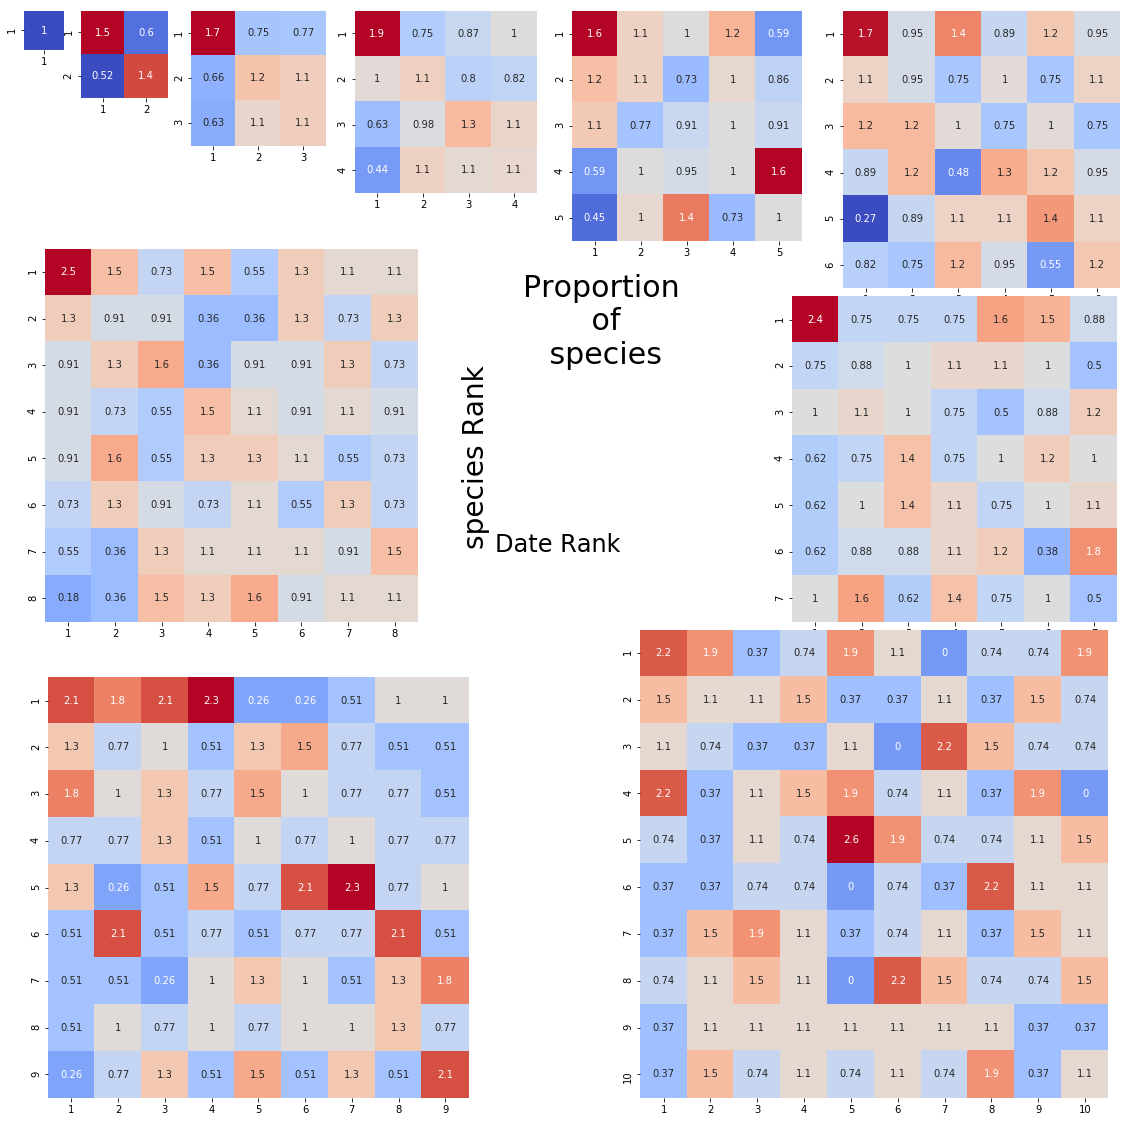

In [115]:
locs = {1:(1,1),2:(1,2),3:(1,4),4:(1,7),5:(1,11),6:(1,16),7:(7,15),8:(6,1),9:(15,1),10:(14,12)}
plt.figure(figsize = (20,20))
i = 0
ret = {}
for k in tables:
    i+=1
    
    temp = pd.DataFrame(tables[k])
    temp.index = range(1,len(temp)+1)
    print(temp)
    spg = len(temp)
    obs = 0
    for c in temp:
        obs += temp[c].sum()
    Ginspg =obs/spg
    print(obs)
    print(Ginspg)
    
    for c in temp.index:
        
    for c in temp:
        temp[c] = [e/temp[c].sum()/(1/len(temp)) for e in temp[c]]
    where = locs[i]
    pltNum = where[0]*21+where[1]
    
    plt.subplot2grid((23,21),(where[0]-1, where[1]-1),colspan = i, rowspan = i)
    sns.heatmap(temp, annot = True, cmap = 'coolwarm', center = 1,square = True, cbar = False)
plt.subplot2grid((23,21),(5,8), colspan = 5, rowspan = 5)

plt.xlabel('hi')
plt.ylabel('no')
plt.axis('equal')
plt.axis('off')
plt.text(-0.05,-0.01,'species Rank', rotation = 'vertical', fontsize = 28)#, horizontalalignment = 'right')
plt.text(-0.036,-0.08,'Date Rank', rotation = 'horizontal', fontsize = 24)#, horizontalalignment = 'left')
plt.text(0.009,0.00,'Proportion\n of\n species', fontsize = 30, horizontalalignment = 'center')
#plt.title('yup')

     1
1  902
902
902.0
     1    2
1  296  120
2  104  280
800
200.0
     1   2   3
1  127  56  57
2   49  88  83
3   47  79  83
669
74.33333333333333
    1   2   3   4
1  81  32  37  43
2  44  49  34  35
3  27  42  55  47
4  19  48  45  46
684
42.75
    1   2   3   4   5
1  36  24  22  27  13
2  26  24  16  23  19
3  25  17  20  22  20
4  13  22  21  22  36
5  10  23  31  16  22
550
22.0
    1   2   3   4   5   6
1  25  14  21  13  17  14
2  16  14  11  15  11  16
3  18  18  15  11  15  11
4  13  18   7  19  17  14
5   4  13  16  16  20  16
6  12  11  18  14   8  17
528
14.666666666666666
    1   2   3   4   5   6   7
1  19   6   6   6  13  12   7
2   6   7   8   9   9   8   4
3   8   9   8   6   4   7  10
4   5   6  11   6   8  10   8
5   5   8  11   9   6   8   9
6   5   7   7   9  10   3  14
7   8  13   5  11   6   8   4
392
8.0
    1  2  3  4  5  6  7  8
1  14  8  4  8  3  7  6  6
2   7  5  5  2  2  7  4  7
3   5  7  9  2  5  5  7  4
4   5  4  3  8  6  5  6  5
5   5  9  3  7  7  

Text(0.009,0,'Proportion\n of\n species')

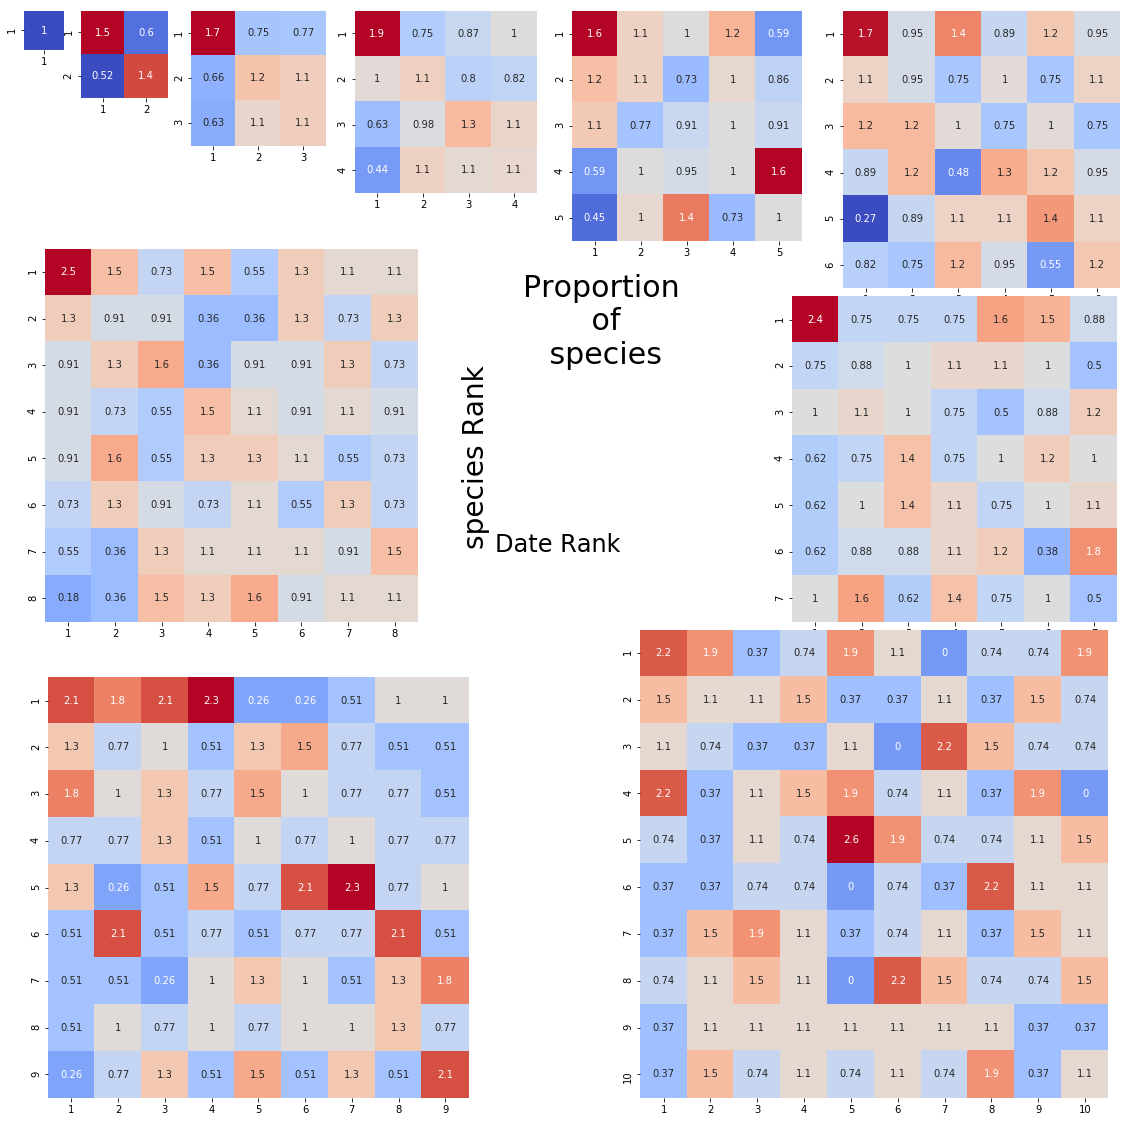

In [112]:
locs = {1:(1,1),2:(1,2),3:(1,4),4:(1,7),5:(1,11),6:(1,16),7:(7,15),8:(6,1),9:(15,1),10:(14,12)}
plt.figure(figsize = (20,20))
i = 0
for k in tables:
    i+=1
    
    temp = pd.DataFrame(tables[k])
    temp.index = range(1,len(temp)+1)
    print(temp)
    spg = len(temp)
    obs = 0
    for c in temp:
        obs += temp[c].sum()
    Ginspg =obs/(spg**2)
    print(obs)
    print(Ginspg)
    for c in temp:
        temp[c] = [e/temp[c].sum()/(1/len(temp)) for e in temp[c]]
    where = locs[i]
    pltNum = where[0]*21+where[1]
    
    plt.subplot2grid((23,21),(where[0]-1, where[1]-1),colspan = i, rowspan = i)
    sns.heatmap(temp, annot = True, cmap = 'coolwarm', center = 1,square = True, cbar = False)
plt.subplot2grid((23,21),(5,8), colspan = 5, rowspan = 5)

plt.xlabel('hi')
plt.ylabel('no')
plt.axis('equal')
plt.axis('off')
plt.text(-0.05,-0.01,'species Rank', rotation = 'vertical', fontsize = 28)#, horizontalalignment = 'right')
plt.text(-0.036,-0.08,'Date Rank', rotation = 'horizontal', fontsize = 24)#, horizontalalignment = 'left')
plt.text(0.009,0.00,'Proportion\n of\n species', fontsize = 30, horizontalalignment = 'center')
#plt.title('yup')